# City of Ottawa bicycle count data analysis

This notebook loads the bicycle count data, does some minimal cleaning, and produces a few figures.

The data was downloaded from the [City of Ottawa open data portal](https://open.ottawa.ca/datasets/bicycle-trip-counters).

The metadata with collection information and location descriptions is [here](https://www.arcgis.com/home/item.html?id=f218592c7fe74788906cc6a0eb190af9).

In [1]:
# load packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# load the excel file using pandas
# requires the package openpyxl
xls = pd.ExcelFile('data/bike_counter.xlsx')

The Excel file the city provides has a different sheet for each year of data collection. We can load the entire file and then loop through each of the sheets.

In [3]:
# the date and header format for 2010-2012 is different, will require extra parsing
# 2013 has a note at the bottom which breaks the parsing
years = np.arange(2013, 2022, 1)
dataframes = []
for year in years:
    dataframes.append(pd.read_excel(xls, str(year), header = 0))

## Cleaning the dates and removing annotations

Unfortunately several different date formats are used, so we have to be careful when converting the dates to a standard format.

Here, we loop through each sheet separately and parse the dates into a `datetime` object.

2014 & 2015 go okay, 2016 needs special attention, so does 2017

In [4]:
dataframes_datetime = []

for i, df in enumerate(dataframes):
    year = years[i]
    if year == 2013: # remove note at the bottom
        df = df.iloc[:365]
    elif year == 2016: # date format changes between March and April 2016
        df1 = df.iloc[:91] # convert normally
        df2 = df.iloc[91:] # use dayfirst = True
        
        df1['date_dt'] = pd.to_datetime(df1['Date'])
        df2['date_dt'] = pd.to_datetime(df2['Date'], dayfirst = True)
    
        df = pd.concat([df1, df2]) # stick them back together
        
    elif year == 2017:
        df['date_dt'] = pd.to_datetime(df['Date'], dayfirst = True)
        
    else:
        df['date_dt'] = pd.to_datetime(df['Date'])
    
    dataframes_datetime.append(df)
    
    

<ipython-input-4-c6dbc7def1ce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date_dt'] = pd.to_datetime(df1['Date'])
<ipython-input-4-c6dbc7def1ce>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date_dt'] = pd.to_datetime(df2['Date'], dayfirst = True)


In [5]:
# smoosh all the years together into one big table
count_data = pd.concat(dataframes_datetime)

In [6]:
# take a look at the column names (these are mostly locations)
count_data.columns

Index(['Date', '1^ALEX', '2^ORPY', '3^COBY', '4^CRTZ', '5^LMET', '6^LLYN',
       '7^LBAY', '8^SOMO', '9 OYNG', '10^OGLD', '11^OBVW', 'Portage Bridge',
       '9 OYNG 1', '11 OBVW', 'date_dt', '12a^ADAWE', '12b^ADAWE',
       'Unnamed: 10', 'Note:',
       '1. ALEX: internal Battery failed in August 2019.'],
      dtype='object')

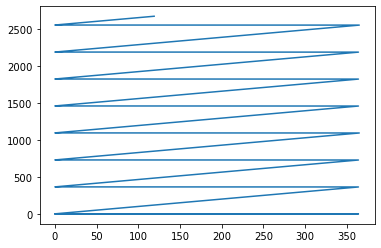

In [7]:
# check if the dates are in order (they are entered in order in the spreadsheet)
plt.plot(np.argsort(count_data['date_dt']))

Looks like we parsed the dates correctly!

Text(0, 0.5, 'Count')

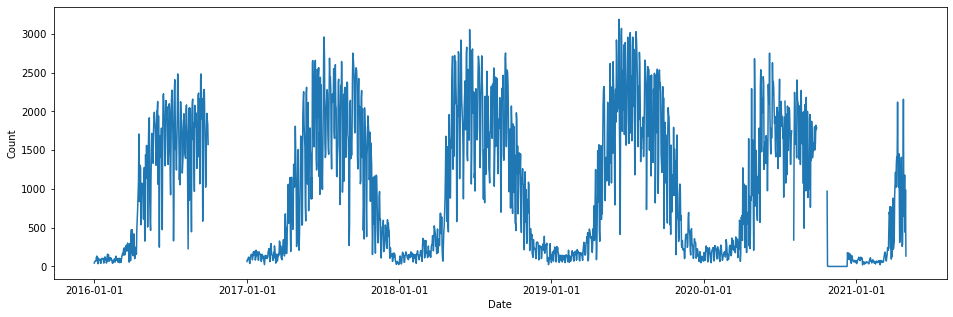

In [8]:
# plot one location to get a feel for the data
# 12a^ADAWE is the bicycle counter, 12b^ADAWE is the pedestrian counter
fig, ax = plt.subplots(figsize = (16,5))

ax.plot(count_data['date_dt'], count_data['12a^ADAWE'])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel("Date")
ax.set_ylabel("Count")

In [9]:
# drop columns created from text notes
count_data = count_data.drop(columns=['Unnamed: 10', 'Note:', '1. ALEX: internal Battery failed in August 2019.'])

In [10]:
# check out what's left after dropping unused columns
count_data.columns

Index(['Date', '1^ALEX', '2^ORPY', '3^COBY', '4^CRTZ', '5^LMET', '6^LLYN',
       '7^LBAY', '8^SOMO', '9 OYNG', '10^OGLD', '11^OBVW', 'Portage Bridge',
       '9 OYNG 1', '11 OBVW', 'date_dt', '12a^ADAWE', '12b^ADAWE'],
      dtype='object')

There are a few column names that should be grouped, like '11 OBVW' and '11^OBVW', same for 9.

In [11]:
# reshape data to long format for faceting
count_data = pd.melt(count_data, id_vars = ['Date', 'date_dt'])

In [12]:
# get month-day for overlaying plots
# use dt.strftime('%b-%d' for months in abbreviated words)
count_data['month_day'] = count_data['date_dt'].dt.strftime('%m-%d')

In [13]:
# rename variable and value columns resulting from melt
count_data = count_data.rename(columns={"variable": "location", "value": "count"})

In [14]:
# convert counts to numbers, make dashes into NaN
count_data['count'] = pd.to_numeric(count_data['count'], errors = 'coerce')

In [15]:
# make year and month columns
count_data['year'] = count_data['date_dt'].dt.year
count_data['month'] = count_data['date_dt'].dt.month

## Add human-readable location names

This is copied from the [metadata](https://www.arcgis.com/home/item.html?id=f218592c7fe74788906cc6a0eb190af9).

1_ALEX: Ottawa approach to the NCC Alexandra Bridge Bikeway This counter was not operational for most of 2010 due to bridge construction

2_ORPY: NCC Ottawa River Pathway approximately 100m east of the Prince of Wales Bridge

3_COBY: NCC Eastern Canal Pathway approximately 100m north of the Corktown Bridge. WINTER counter

4_CRTZ: NCC Western Canal Pathway approximately 200m north of “The Ritz”

5_LMET Laurier Segregated Bike lane just west of Metcalfe WINTER counter

6_LLYN Laurier Segregated Bike lane just east of Lyon. WINTER counter

7_LBAY Laurier Segregated Bike lane just west of Bay. WINTER counter

8_SOMO Somerset bridge over O-Train west-bound direction only WINTER counter (best effort- see notes)

9_OYNG O-Train Pathway just north of Young Street

10_OGLD O-Train Pathway just north of Galdstone Avenue

11_OBVW O-Train Pathway just north of Bayview Station

12a_ADAWE Adàwe Crossing Bikes. WINTER counter

12b_ADAWE Adàwe Crossing Pedestrians. WINTER counter

In [16]:
# Add human-readable location names
# nothing for it but to do this manually

locations = count_data['location'].unique()
print(locations)

# make this a dictionary so that it's stable if the column names move around at all
location_names_dict = {"1^ALEX" : "Alexandra Bridge",
                       "2^ORPY" : "ORP Prince of Wales",
                       "3^COBY" : "Canal Path East, Corktown",
                       "4^CRTZ" : "Canal Path West, Ritz",
                       "5^LMET" : "Laurier at Metcalfe",
                       "6^LLYN" : "Laurier at Lyon",
                       "7^LBAY" : "Laurier at Bay",
                       "8^SOMO" : "Somerset Bridge",
                       "9 OYNG 1" : "O-Train Path, Young",
                       "9^OYNG" : "O-Train Path, Young",
                       "10^OGLD" : "O-Train Path, Gladstone",
                       "11 OBVW" : "O-Train Path, Bayview",
                       "11^OBVW" : "O-Train Path, Bayview",
                       "Portage Bridge" : "Portage Bridge",
                       "12a^ADAWE" : "Adàwe Crossing, bikes",
                       "12b^ADAWE" : "Adàwe Crossing, pedestrians"}

# make a new column with human-readable location names
count_data["location_name"] = count_data['location'].map(location_names_dict)

['1^ALEX' '2^ORPY' '3^COBY' '4^CRTZ' '5^LMET' '6^LLYN' '7^LBAY' '8^SOMO'
 '9 OYNG' '10^OGLD' '11^OBVW' 'Portage Bridge' '9 OYNG 1' '11 OBVW'
 '12a^ADAWE' '12b^ADAWE']


In [17]:
# take a look at our new column:
count_data.head()

,Date,date_dt,location,count,month_day,year,month,location_name
0,2013-01-01 00:00:00,NaT,1^ALEX,0.0,NaN,NaN,NaN,Alexandra Bridge
1,2013-01-02 00:00:00,NaT,1^ALEX,0.0,NaN,NaN,NaN,Alexandra Bridge
2,2013-01-03 00:00:00,NaT,1^ALEX,0.0,NaN,NaN,NaN,Alexandra Bridge
3,2013-01-04 00:00:00,NaT,1^ALEX,0.0,NaN,NaN,NaN,Alexandra Bridge
4,2013-01-05 00:00:00,NaT,1^ALEX,0.0,NaN,NaN,NaN,Alexandra Bridge


## Plot a single location

As a first fun thing, it could be neat to look for a covid-related change in bike counts.
What do we expect: commuting decreased, recreational cycling increased?

In [18]:
# look for a covid-related signal at one location for starters?
# 3_COBY: NCC Eastern Canal Pathway approximately 100m north of the Corktown Bridge. WINTER counter 
canal_path_corktown = count_data[count_data['location'] == '3^COBY']

In [19]:
canal_path_grouped_by_year = canal_path_corktown.groupby('year')

In [20]:
canal_path_grouped = canal_path_corktown.groupby(['year', 'month'])

In [21]:
canal_path_stats = canal_path_grouped['count'].agg(['mean', 'std', 'sum'])


Text(0, 0.5, 'Bike count')

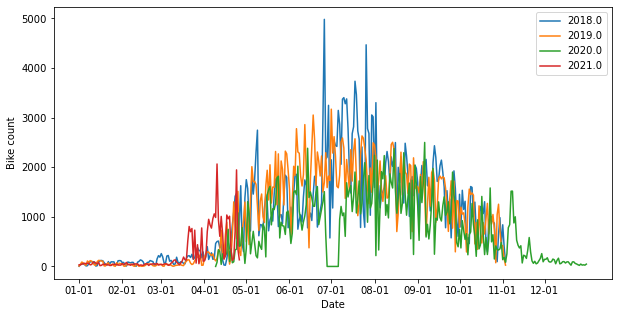

In [22]:
fig, ax = plt.subplots(figsize = (10,5))

for group in canal_path_grouped_by_year:
    year = group[0]
    data = group[1]
    
    if year < 2018:
        continue
    
    ax.plot(data['month_day'], data['count'], label = str(year))

ax.legend(loc = 'upper right')

ax.set_xticks(['01-01', '02-01','03-01','04-01','05-01','06-01','07-01','08-01','09-01','10-01', '11-01', '12-01'])
ax.set_xlabel("Date")
ax.set_ylabel("Bike count")

In [23]:
canal_path_corktown_recent = canal_path_corktown[(canal_path_corktown['year'] > 2016)]

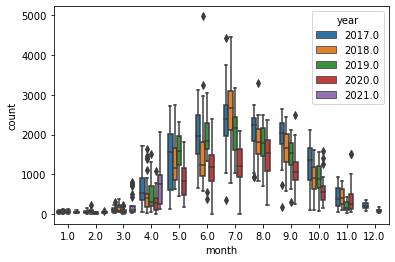

In [24]:
sns.boxplot(x='month', y='count', data=canal_path_corktown_recent, hue = 'year')
plt.savefig("bike_counts_by_month_canal_path_corktown_east.png", dpi = 150)

## Plot multiple locations

The following plot compares all bike counter locations for the years 2017 to 2020. 

For most locations, counts seem to be down in 2020 compared to previous years. One extreme example is LMET, the Laurier bike lane west of Metcalfe. I assume this is way down because people aren't commuting to work downtown? On the other hand, there is a noticeable 2020 uptick for 12b Adawe, which is the Adawe crossing pedestrian counter (12a Adawe is bikes). 

In [25]:
count_data_recent = count_data[(count_data['year'] > 2016)]

In [26]:
# remove OYNG, LBAY, and Portage - no data for these years
count_data_recent = count_data_recent[(count_data['location'] != '6^LLYN') & 
                 (count_data['location'] != '9 OYNG 1') &
                 (count_data['location'] != '9^OYNG') &
                 (count_data['location'] != '7^LBAY') &
                 (count_data['location'] != 'Portage Bridge')]

<ipython-input-26-b178954c4f06>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_data_recent = count_data_recent[(count_data['location'] != '6^LLYN') &


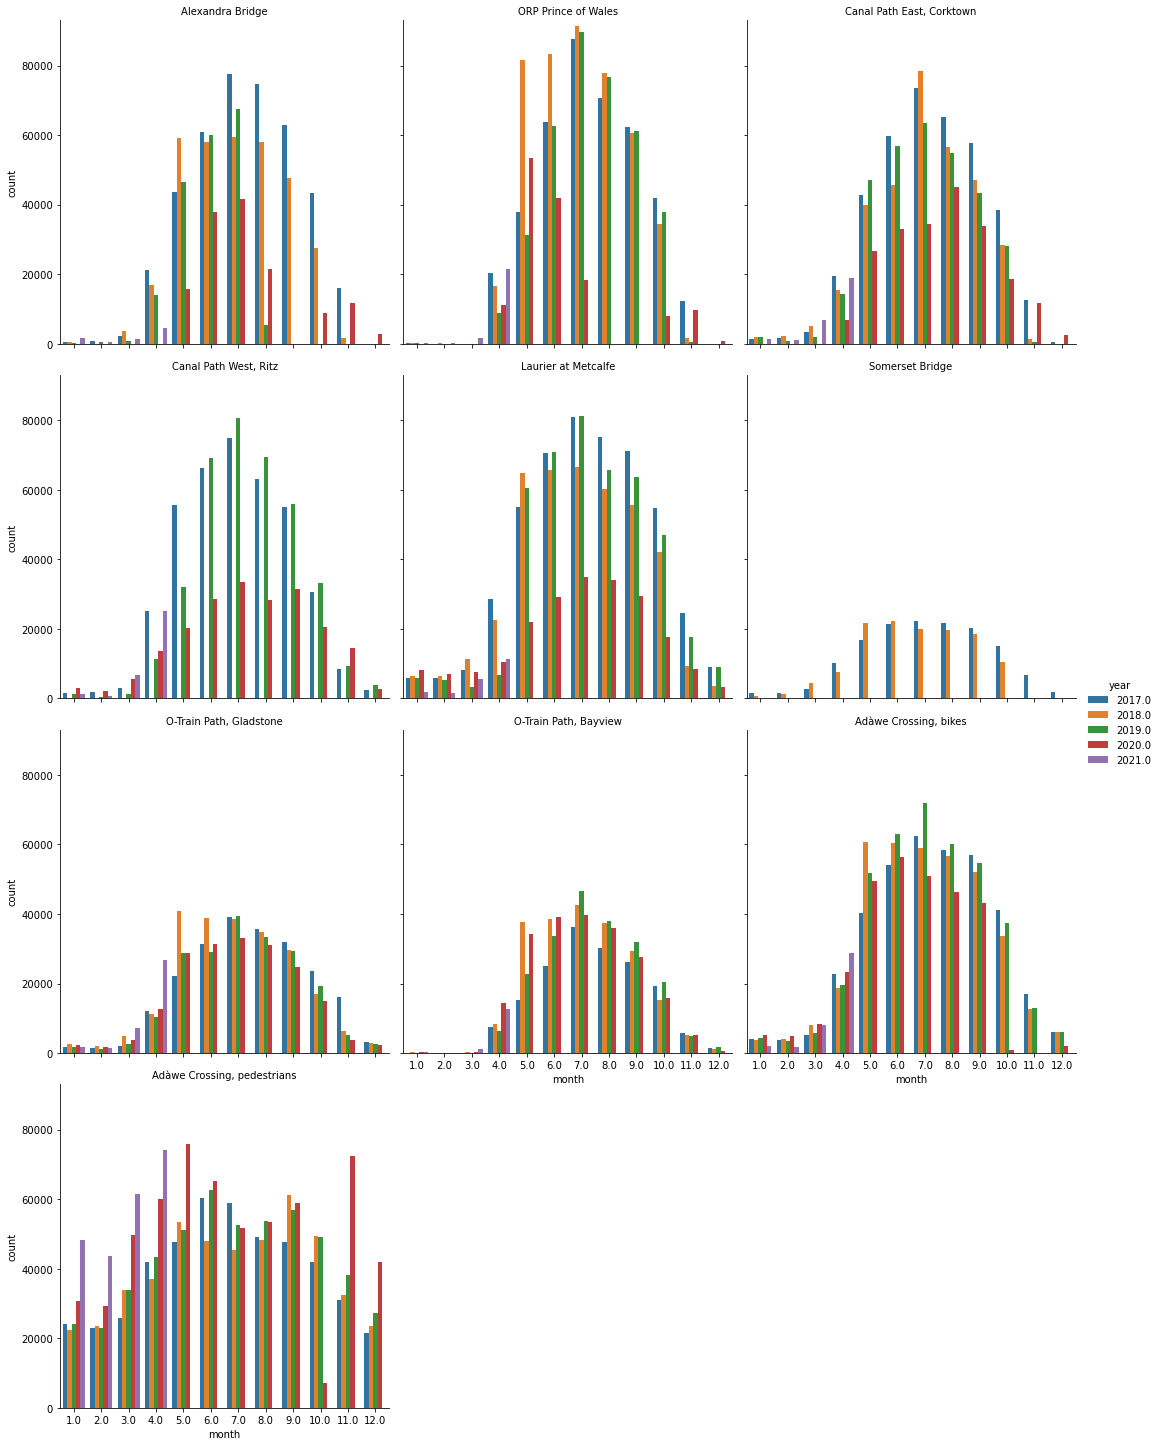

In [27]:
g = sns.catplot(x = 'month', y = 'count', col = 'location_name', col_wrap = 3, data = count_data_recent,
              hue = 'year', kind = 'bar', estimator = sum, ci = None) # each bar is the sum of all the days in the month
g.set(ylim=(None, 9.3*10**4))
g.set_titles(col_template = '{col_name}') # rename subplots, code from here: https://wckdouglas.github.io/2016/12/seaborn_annoying_title
plt.savefig("bike_counts_2017_2020_all_locations.png", dpi = 200)